# Task 4: Training Variational Autoencoders

In [1]:
# ---------------- IMPORTS ----------------
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# ---------------- DATASET ----------------
def get_dataloaders(batch_size=64):
    transform = transforms.ToTensor()
    train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_ds = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, train_ds, test_ds


# ---------------- MODEL ----------------
# class VAE(nn.Module):
#     def __init__(self, hidden_dim=400, latent_dim=20):
#         super().__init__()
#         self.fc1 = nn.Linear(28*28, hidden_dim)
#         self.fc_mu = nn.Linear(hidden_dim, latent_dim)
#         self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
#         self.fc2 = nn.Linear(latent_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, 28*28)

#     def encode(self, x):
#         h = nn.functional.relu(self.fc1(x))
#         return self.fc_mu(h), self.fc_logvar(h)

#     def reparameterize(self, mu, logvar):
#         std = (0.5 * logvar).exp()
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         h = nn.functional.relu(self.fc2(z))
#         return torch.sigmoid(self.fc3(h))

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, 28*28))
#         z = self.reparameterize(mu, logvar)
#         recon = self.decode(z)
#         return recon, mu, logvar

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 28x28 -> 14x14
        self.enc_conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 14x14 -> 7x7
        self.enc_fc = nn.Linear(64*7*7, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 256)
        self.dec_fc2 = nn.Linear(256, 64*7*7)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1) # 7x7 -> 14x14
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = x.view(x.size(0), -1)
        h = F.relu(self.enc_fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.dec_fc(z))
        h = F.relu(self.dec_fc2(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.dec_deconv1(h))
        x_recon = torch.sigmoid(self.dec_deconv2(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ---------------- LOSS ----------------
def loss_fn(recon, x, mu, logvar, kl_weight=1.0):
    # Flatten both
    recon = recon.view(recon.size(0), -1)
    x = x.view(x.size(0), -1)
    
    # bce = nn.functional.binary_cross_entropy(recon, x.view(-1, 28*28), reduction='sum')
    mse = nn.functional.mse_loss(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kl_weight * kld, mse, kld

# ---------------- TRAINING ----------------
def train_vae(epochs, train_loader, test_loader, latent_dim=20, lr=1e-3, kl_schedule=False):
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0

        # KL annealing if enabled
        kl_weight = 1.0
        if kl_schedule:
            kl_weight = (epoch-1) / (epochs-1)  # linear 0 → 1
            # min(0.5, epoch / epochs)

        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
        for x, _ in loop:
            x = x.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(x)
            loss, bce, kld = loss_fn(recon, x, mu, logvar, kl_weight)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                recon, mu, logvar = model(x)
                loss, _, _ = loss_fn(recon, x, mu, logvar)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: Train {avg_train_loss:.4f} | Val {avg_val_loss:.4f} | KL weight {kl_weight:.2f}")

    return model, train_losses, val_losses

In [2]:
# ---------------- VISUALIZATIONS ----------------
def plot_reconstructions(model, test_ds, n=8):
    model.eval()
    idx = torch.randperm(len(test_ds))[:n]
    orig = torch.stack([test_ds[i][0] for i in idx]).to(device)

    with torch.no_grad():
        recon, _, _ = model(orig)

    orig = orig.cpu().squeeze()
    recon = recon.view(-1, 1, 28, 28).cpu().squeeze()

    plt.figure(figsize=(8,4))
    for i in range(n):
        plt.subplot(2,n,i+1)
        plt.imshow(orig[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2,n,n+i+1)
        plt.imshow(recon[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Top: Originals | Bottom: Reconstructions")
    plt.show()


def plot_generations(model, latent_dim, n=10, prior="gaussian"):
    model.eval()
    if prior == "gaussian":
        z = torch.randn(n, latent_dim).to(device)
        title = "Generated Samples (Gaussian prior)"
    elif prior == "laplace":
        laplace = torch.distributions.Laplace(torch.tensor(0.0), torch.tensor(1.0))
        z = laplace.sample((n, latent_dim)).to(device)
        title = "Generated Samples (Laplace prior)"

    with torch.no_grad():
        samples = model.decode(z).view(-1, 1, 28, 28).cpu().squeeze()

    plt.figure(figsize=(5,2))
    for i in range(n):
        plt.subplot(2,5,i+1)
        plt.imshow(samples[i], cmap='gray'); plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [3]:
# ---------------- ANALYSIS ----------------
def analyze_posterior_collapse(model, test_loader):
    model.eval()
    recon_losses, kl_losses = [], []
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            total, bce, kld = loss_fn(recon, x, mu, logvar)
            recon_losses.append(bce.item() / len(x))
            kl_losses.append(kld.item() / len(x))

    print(f"Avg Recon Loss: {np.mean(recon_losses):.2f}")
    print(f"Avg KL Divergence: {np.mean(kl_losses):.2f}")

In [4]:
def run_experiment(epochs=10, latent_dim=20, kl_schedule=False):
    # Data
    train_loader, test_loader, train_ds, test_ds = get_dataloaders()

    # Train
    model, train_losses, val_losses = train_vae(
        epochs, train_loader, test_loader, latent_dim, kl_schedule=kl_schedule
    )

    # Reconstructions
    plot_reconstructions(model, test_ds)

    # Generations
    plot_generations(model, latent_dim, prior="gaussian")
    plot_generations(model, latent_dim, prior="laplace")

    # Collapse analysis
    analyze_posterior_collapse(model, test_loader)

    return model

Training Standard VAE...


Epoch 1: Train 34.5925 | Val 27.3968 | KL weight 1.00


Epoch 2: Train 26.4291 | Val 25.6631 | KL weight 1.00


Epoch 3: Train 25.3582 | Val 25.2906 | KL weight 1.00


Epoch 4: Train 24.8276 | Val 24.7021 | KL weight 1.00


Epoch 5: Train 24.4979 | Val 24.2959 | KL weight 1.00


Epoch 6: Train 24.2294 | Val 24.1092 | KL weight 1.00


Epoch 7: Train 24.0312 | Val 24.2982 | KL weight 1.00


Epoch 8: Train 23.9003 | Val 24.0580 | KL weight 1.00


Epoch 9: Train 23.7599 | Val 23.8991 | KL weight 1.00


Epoch 10: Train 23.6633 | Val 23.7977 | KL weight 1.00


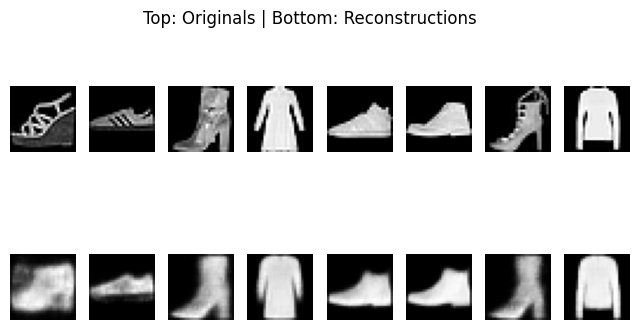

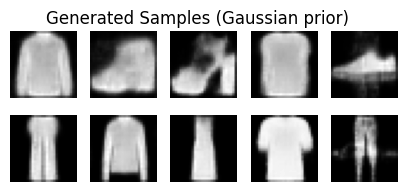

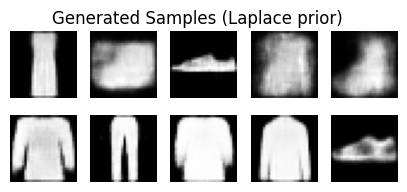

Avg Recon Loss: 15.82
Avg KL Divergence: 8.09

Training VAE with KL Annealing...


Epoch 1: Train 18.9247 | Val 336.9030 | KL weight 0.00


Epoch 2: Train 15.8971 | Val 41.4361 | KL weight 0.11


Epoch 3: Train 16.8911 | Val 34.0865 | KL weight 0.22


Epoch 4: Train 18.2539 | Val 29.9793 | KL weight 0.33


Epoch 5: Train 19.4661 | Val 27.3147 | KL weight 0.44


Epoch 6: Train 20.6395 | Val 26.1509 | KL weight 0.56


Epoch 7: Train 21.6984 | Val 25.2281 | KL weight 0.67


Epoch 8: Train 22.6457 | Val 24.9183 | KL weight 0.78


Epoch 9: Train 23.5316 | Val 24.6703 | KL weight 0.89


Epoch 10: Train 24.3385 | Val 24.5487 | KL weight 1.00


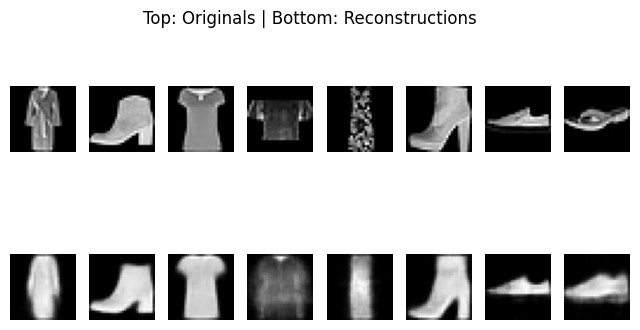

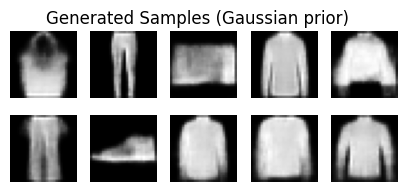

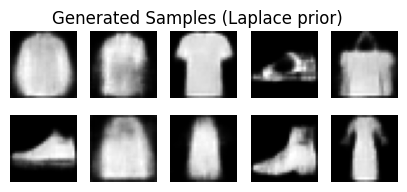

Avg Recon Loss: 15.27
Avg KL Divergence: 9.27


In [5]:
print("Training Standard VAE...")
vae_model = run_experiment(epochs=10, latent_dim=20, kl_schedule=False)

print("\nTraining VAE with KL Annealing...")
vae_annealed = run_experiment(epochs=10, latent_dim=20, kl_schedule=True)

In [6]:
import torch
import matplotlib.pyplot as plt

def visualize_vae_results(model, test_loader, latent_dim=20, n_samples=8, prior="gaussian"):
    model.eval()
    device = next(model.parameters()).device
    test_iter = iter(test_loader)
    x, _ = next(test_iter)
    x = x.to(device)

    # ---- Reconstructions ----
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        x_recon = model.decode(z)

    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*2, 4))
    for i in range(n_samples):
        axes[0,i].imshow(x[i,0].cpu(), cmap="gray")
        axes[0,i].axis("off")
        axes[1,i].imshow(x_recon[i,0].cpu(), cmap="gray")
        axes[1,i].axis("off")
    plt.suptitle("Top: Original | Bottom: Reconstructions")
    plt.show()

    # ---- Generations from Prior ----
    if prior == "gaussian":
        z = torch.randn(n_samples, latent_dim).to(device)
    elif prior == "laplacian":
        z = torch.distributions.laplace.Laplace(0,1).sample((n_samples, latent_dim)).to(device)

    with torch.no_grad():
        samples = model.decode(z)

    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))
    for i in range(n_samples):
        axes[i].imshow(samples[i,0].cpu(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle(f"Generations from {prior} prior")
    plt.show()

    # ---- Interpolations ----
    z1, z2 = torch.randn(1, latent_dim).to(device), torch.randn(1, latent_dim).to(device)
    alphas = torch.linspace(0,1,n_samples).to(device)
    zs = torch.cat([(1-a)*z1 + a*z2 for a in alphas], dim=0)

    with torch.no_grad():
        interps = model.decode(zs)

    fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))
    for i in range(n_samples):
        axes[i].imshow(interps[i,0].cpu(), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Latent Interpolation")
    plt.show()


-------- VISUALIZING VANILLA VAE WITH GAUSSIAN PRIOR -------


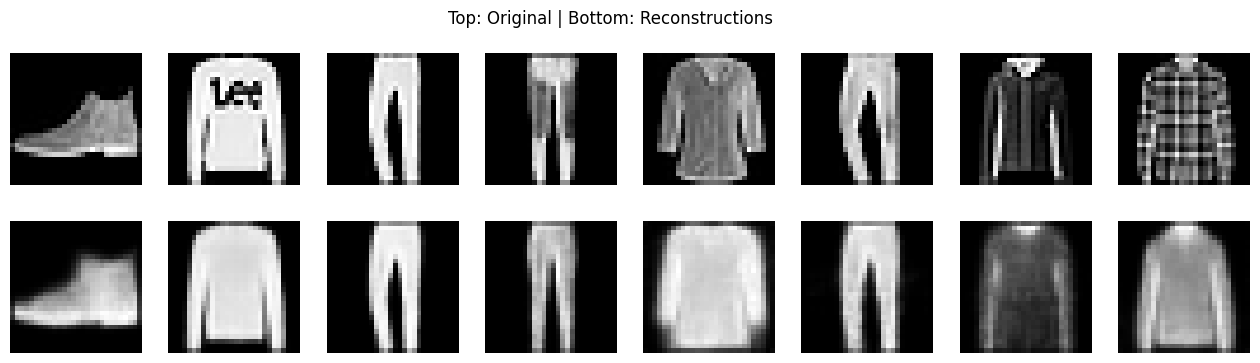

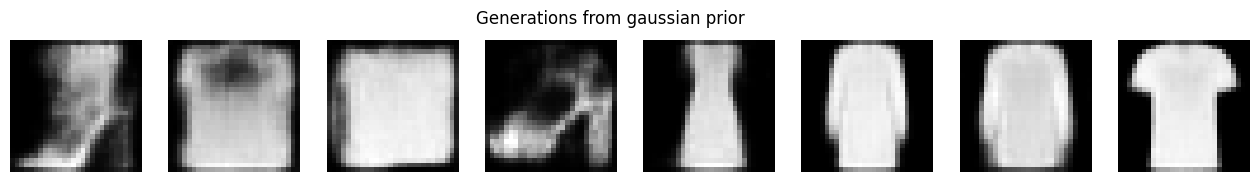

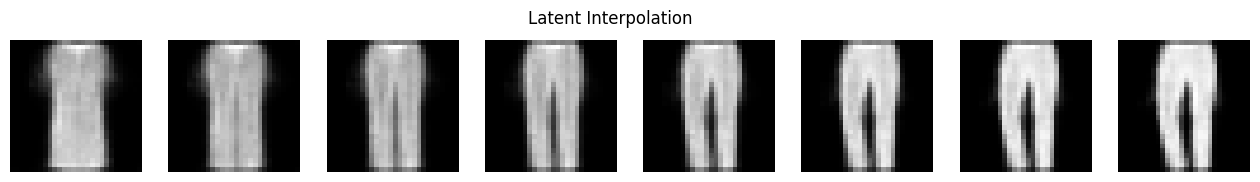

-------- VISUALIZING KL ANNEALED VAE WITH GAUSSIAN PRIOR -------


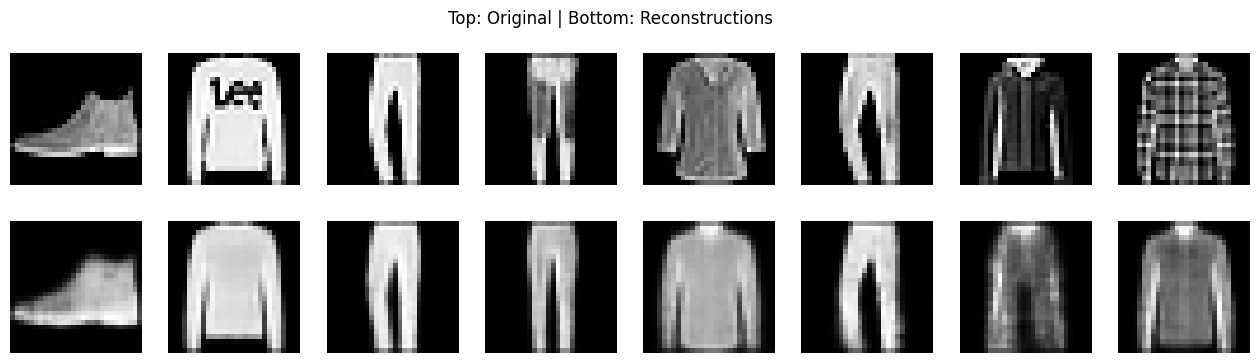

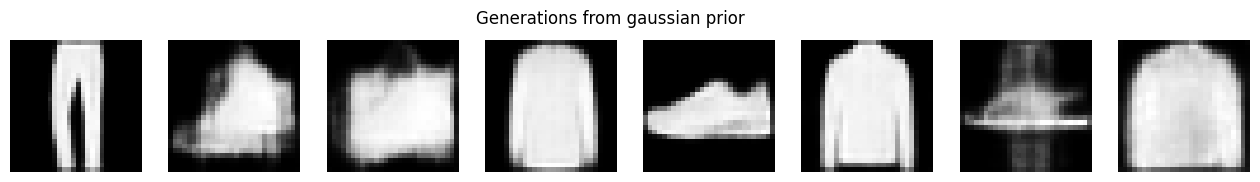

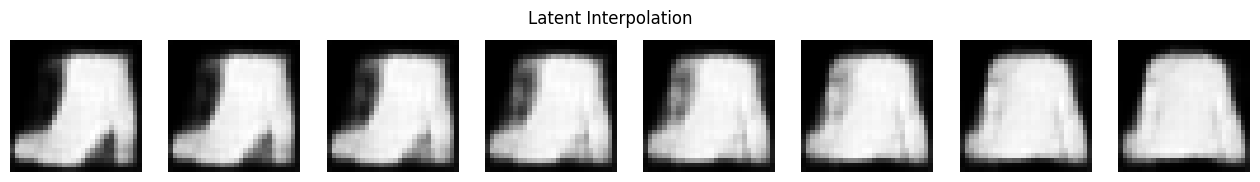

-------- VISUALIZING KL ANNEALED VAE WITH LAPLACIAN PRIOR -------


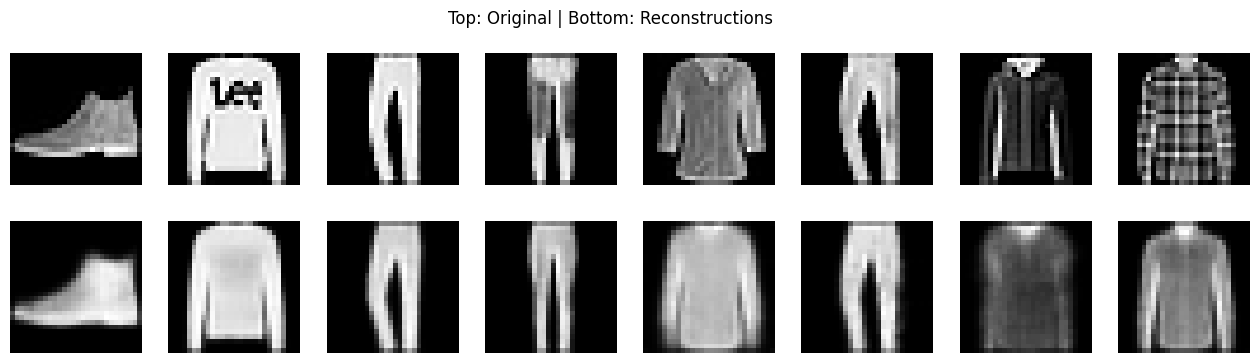

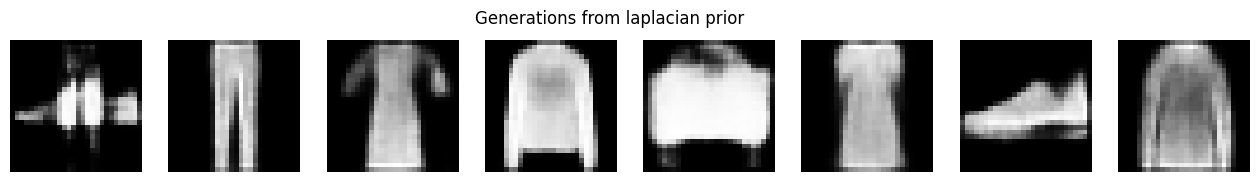

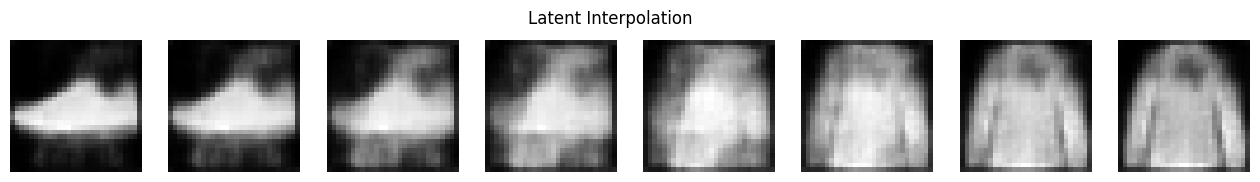

In [7]:
_, test_loader, _, _ = get_dataloaders()

print("-------- VISUALIZING VANILLA VAE WITH GAUSSIAN PRIOR -------")
visualize_vae_results(vae_model, test_loader, latent_dim=20, prior="gaussian")
print("-------- VISUALIZING KL ANNEALED VAE WITH GAUSSIAN PRIOR -------")
visualize_vae_results(vae_annealed, test_loader, latent_dim=20, prior="gaussian")
print("-------- VISUALIZING KL ANNEALED VAE WITH LAPLACIAN PRIOR -------")
visualize_vae_results(vae_annealed, test_loader, latent_dim=20, prior="laplacian")


2(c) Generations from different priors (e.g., Laplacian):
- VAEs are trained assuming Gaussian prior.
- Sampling from a Laplacian prior can lead to less smooth, blurry, incomplete or oddly distributed samples.
- This highlights the importance of matching the assumed prior.

2(d) Observations:
- Reconstructions → faithful to training data, but not diverse, miss out close details like designs.
- Generations → diverse but can look less realistic if KL is weak (posterior not aligned with prior) -> turn out to be blurry on edges, darkened or grayish (colourless).
- Non-Gaussian priors show mismatch → lower quality generations.

3(a) uniform blob - similar samples
- Even though loss decreases, generated samples may look all alike (posterior collapse).
- Collapse = encoder ignores 𝑥, always outputs distribution ~ prior.

3(b) ELBO components
- ELBO = Reconstruction Loss + KL Divergence.
- If KL dominates early → encoder learns to output trivial latent distributions (near 0, std=1).

3(c) investigating posterior collapse (ask)
- Posterior collapse confirmed if (occuring in my samples):
- Reconstructions look fine but generations look like uniform noise.
- KL divergence term ≈ 0 (encoder collapsed to prior).

(d) Why it happens:
- Encoder vs Decoder power: If decoder is very strong, it ignores latent code and reconstructs well anyway.
- KL term early in training: If too strong, encoder learns to match prior too quickly → collapse.

4(a) Strategy:
- Use KL annealing (gradually increase KL weight).
- Or use cyclical annealing (alternate between low KL and high KL).
- Or train encoder more aggressively (higher learning rate).
- KL warm-up lets encoder learn useful features first before being forced to align with prior.

4(c) Comparison:
- Vanilla VAE → sharper reconstructions, poor latent space (Interpolations are basically same fuzzy shirt morphing with little diversity -> not smooth)
- KL annealed VAE → slightly worse reconstructions, but much better generations & latent interpolations.
- The Vanilla VAE produces sharper reconstructions, but its generations from the prior are poor and uninterpretable, showing signs of posterior collapse. The KL-annealed VAE, while producing blurrier reconstructions, yields significantly better generations and smoother latent interpolations, demonstrating a healthier latent space that aligns with the Gaussian prior.